# Predicting House Prices with XGBoost

### Installing XGBoost 

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb
from xgboost import XGBRegressor

### Reading the CSV files

In [5]:
import pandas as pd 

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

### Training the Data

In [7]:
y = train["SalePrice"]
X = train.drop(["SalePrice", "Id"], axis=1)

In [8]:
X = X.select_dtypes(include=["int64", "float64"])
X = X.fillna(X.median())

X_test = test[X.columns]
X_test = X_test.fillna(X_test.median())

### Fitting the Model

In [10]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Making the Predictions

In [12]:
predictions = model.predict(X_test)

In [13]:
submission = pd.DataFrame(
    {
        "Id" : test["Id"],
        "SalePrice" : predictions
    }
)

submission.to_csv("xgb_submissions.csv", index=False)

### Comparison with LightGBM and RandomForest

In [15]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [16]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

### Applying RandomForest Model

In [18]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_preds = rf_model.predict(X_test)


rf_submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": rf_preds
})

rf_submission.to_csv("rf_submission.csv", index=False)


### Applying LightGBM Regressor

In [20]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgb_model.fit(X, y)
lgb_preds = lgb_model.predict(X_test)


lgb_submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": lgb_preds
})

lgb_submission.to_csv("lgb_submission.csv", index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 35
[LightGBM] [Info] Start training from score 180921.195890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor().fit(X_train, y_train)
val_preds = model.predict(X_val)

rmsle = mean_squared_log_error(y_val, val_preds, squared=False)
print("RMSLE:", rmsle)

RMSLE: 0.156766165187672


### Feature Engineering 

We only used numerical data until now. Now, we are gonna add object type data as well.

In [23]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

y = train["SalePrice"]
X_full = train.drop(["SalePrice", "Id"], axis=1)
X_test_full = test.drop("Id", axis=1)

# We are taking the categorical columns
categorical_cols = [col for col in X_full.columns if X_full[col].dtype == "object"]

# We are taking the numerical columns here
numerical_cols = [col for col in X_full.columns if X_full[col].dtype in ['int64', 'float64']]

# Filtering the data here to decide which ones are useful
good_cat_cols = [col for col in categorical_cols if X_full[col].nunique() < 10]

# These are the ones we are gonna use:
my_cols = good_cat_cols + numerical_cols
X = X_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

### One-Hot Encoding

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# First: Filling the Missing Values 
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Second: Transformer Column - Uniting the Numerical and Categorical Values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, good_cat_cols)
    ])

In [26]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Fitting the data
pipeline.fit(X, y)

# Getting a prediction
preds = pipeline.predict(X_test)

submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": preds
})
submission.to_csv("xgb_with_features.csv", index=False)

### Custom Feature Engineering 

In this section, I will do custom feature engineering to make the data more meaningful and richer.

In [29]:
def add_custom_features(df):
    df = df.copy()
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["TotalBath"] = df["FullBath"] + 0.5 * df["HalfBath"]
    df["HasGarage"] = (df["GarageArea"] > 0).astype(int)
    df["IsRemodeled"] = (df["YearBuilt"] != df["YearRemodAdd"]).astype(int)
    df["TotalPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    return df

In [30]:
X = add_custom_features(X_full)
X_test = add_custom_features(X_test_full)

In [50]:
pipeline.fit(X, y)
preds = pipeline.predict(X_test)

submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": preds
})
submission.to_csv("xgb_custom_features.csv", index=False)

It did not change our model's score. We will continue with feature importance analysis.

### Feature Importance Analysis

Our goals to make a feature importance analysis are;
* To analyze which variables depends on XGBoost model
* To decide stronger about feature engineering
* To determine unnecessary features and remove if needed

In [55]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Trained model (XGBRegressor)
model = pipeline.named_steps["model"]

# Getting the feature names
encoder = pipeline.named_steps["preprocessor"]
feature_names = encoder.get_feature_names_out()

# Getting importance values
importances = model.feature_importances_

# Make a table with Pandas
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort values according to its value 
importance_df = importance_df.sort_values(by="Importance", ascending=False)

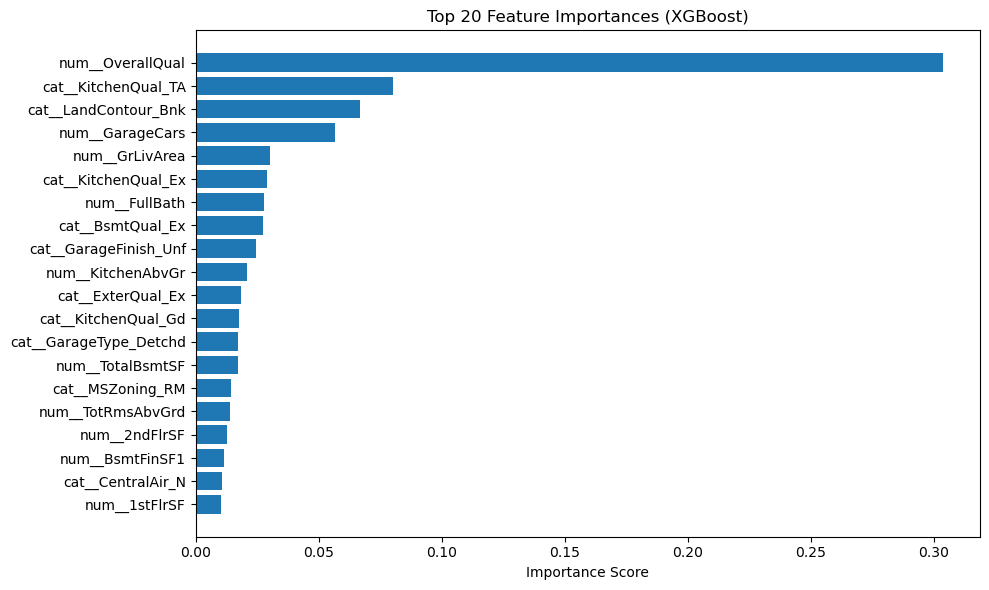

In [57]:
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].iloc[:top_n][::-1], 
         importance_df["Importance"].iloc[:top_n][::-1])
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

We can see that these features are important:
* num_OverallQual
* cat_KitchenQual_TA
* cat_LandContour_Bnk
* num_GrLivArea

Therefore, we will remove some of the unimportant features. 

### Feature Elimination

In [73]:
low_importance_features = importance_df.tail(20)["Feature"].tolist()
X_train_reduced = X_train.drop(columns=low_importance_features, errors='ignore')
X_test_reduced = X_test.drop(columns=low_importance_features, errors='ignore')


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = X_train_reduced.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_reduced.select_dtypes(include=['object', 'category']).columns

# New preprocessor
preprocessor_new = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features)
)

from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

pipeline_new = make_pipeline(
    preprocessor_new,
    XGBRegressor(random_state=42)
)

pipeline_new.fit(X_train_reduced, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'Fu...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test_reduced, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
y_pred = pipeline_new.predict(X_test_reduced)

In [103]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 917089724.0128222
R² Score: 0.8804366725428828


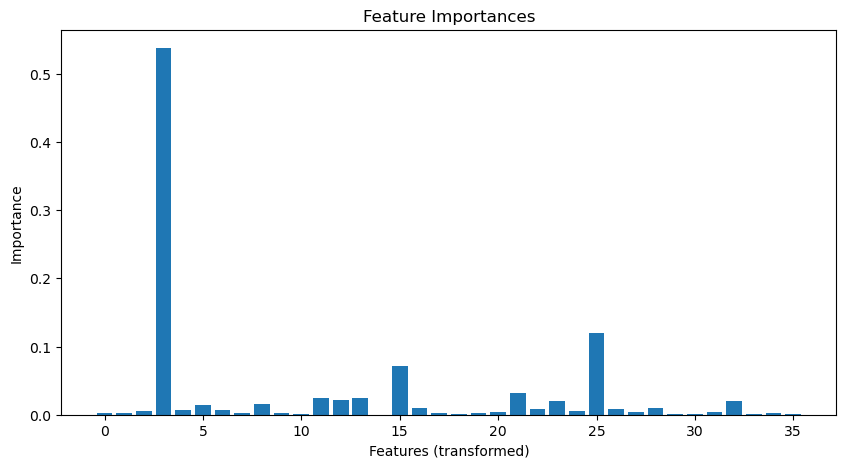

In [105]:
import matplotlib.pyplot as plt

xgb_model = pipeline_new.named_steps['xgbregressor']
importances = xgb_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.xlabel("Features (transformed)")
plt.ylabel("Importance")
plt.show()

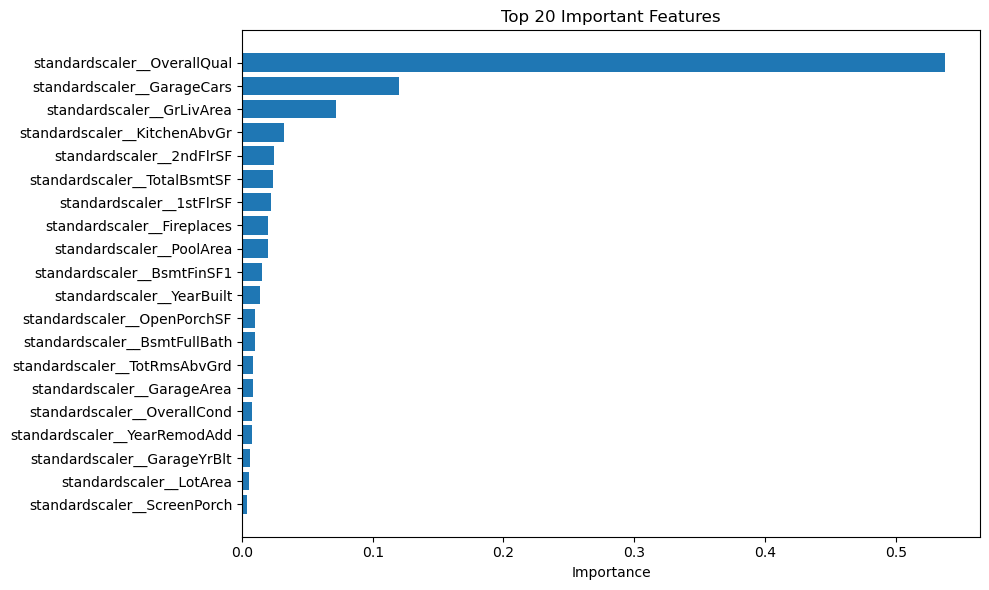

,Feature,Importance
3,standardscaler__OverallQual,0.537552
25,standardscaler__GarageCars,0.119857
15,standardscaler__GrLivArea,0.071803
21,standardscaler__KitchenAbvGr,0.032229
13,standardscaler__2ndFlrSF,0.024799
11,standardscaler__TotalBsmtSF,0.023868
12,standardscaler__1stFlrSF,0.022164
23,standardscaler__Fireplaces,0.019793
32,standardscaler__PoolArea,0.019532
8,standardscaler__BsmtFinSF1,0.015163


In [107]:
column_transformer = pipeline_new.named_steps['columntransformer']

feature_names = column_transformer.get_feature_names_out()

import pandas as pd
import matplotlib.pyplot as plt

xgb_model = pipeline_new.named_steps['xgbregressor']
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

feature_importance_df.head(20)

### Real vs Predicted Value

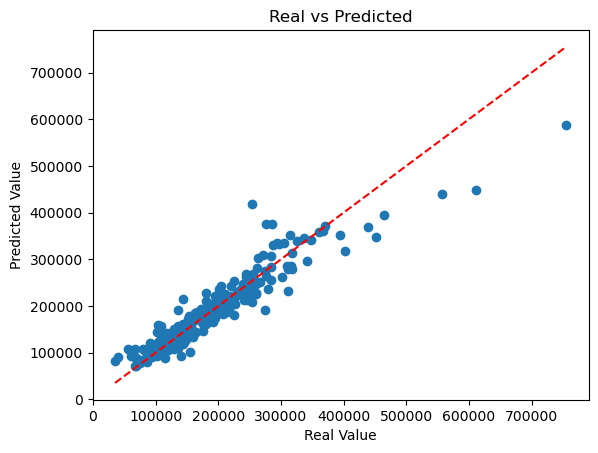

In [109]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Real Value")
plt.ylabel("Predicted Value")
plt.title("Real vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Evaluation with Cross Validation

In [113]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline_new, X_train_reduced, y_train, scoring='r2', cv=5)
print("R² scores from 5-Fold CV:", scores)
print("Average R²:", scores.mean())

R² scores from 5-Fold CV: [0.7898481  0.75010201 0.85750663 0.86581076 0.86029375]
Average R²: 0.8247122504511438


In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__max_depth': [3, 5, 7]
}

grid = GridSearchCV(pipeline_new, param_grid, cv=3, scoring='r2')
grid.fit(X_train_reduced, y_train)

print("Best params:", grid.best_params_)
print("Best R²:", grid.best_score_)


Best params: {'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 100}
Best R²: 0.8633066461307939


In [119]:
import joblib 

joblib.dump(pipeline_new, 'xgb_model_pipeline.pkl')

['xgb_model_pipeline.pkl']

### Conclusion

The XGBoost model achieved an **R² score of 0.86** with optimized hyperparameters via GridSearchCV.
The model performs well in predicting the target variable with minimal overfitting, as seen in the cross-validation scores.

Feature importance analysis revealed that;
* **OverallQual** (Overall material and finish quality)
* **GarageCars** (Size of garage in car capacity)
* **GrLiveArea** (Above grade (ground) living area square feet)

are the most impactful features.
